In [1]:
import numpy as np
import dxchange
import holotomo
import matplotlib.pyplot as plt
import cv2
import xraylib
import random
import scipy.ndimage as ndimage
import tifffile

PLANCK_CONSTANT = 4.135667696e-18  # [keV*s]
SPEED_OF_LIGHT = 299792458  # [m/s]

%matplotlib inline

# Init data sizes and parametes of the PXM of ID16A

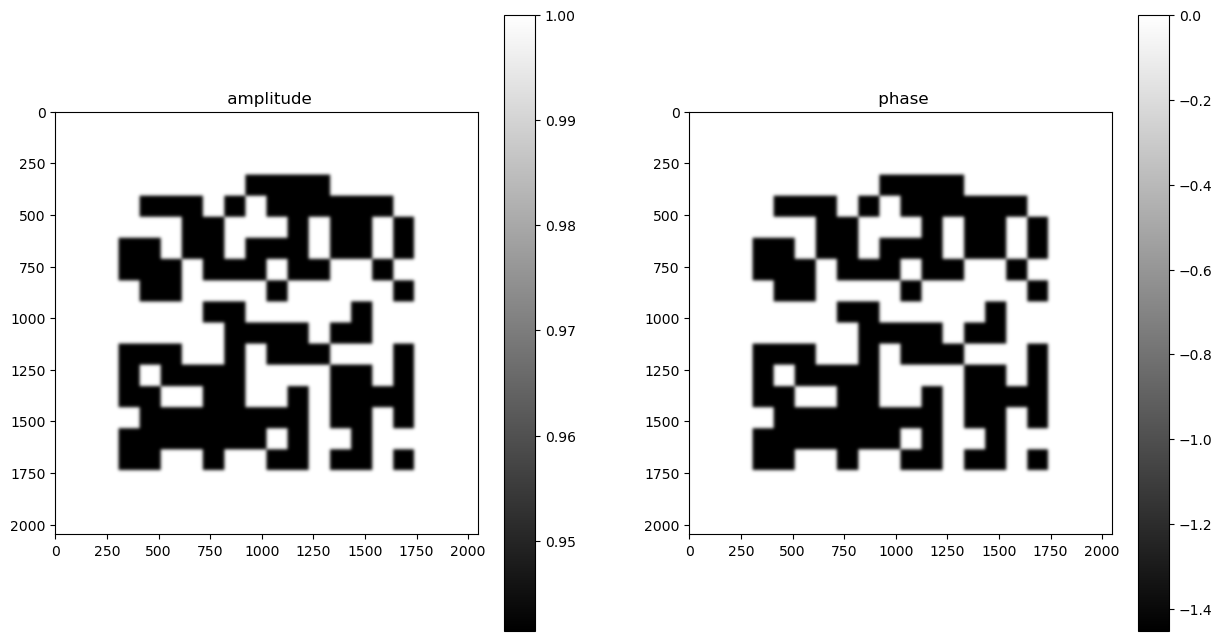

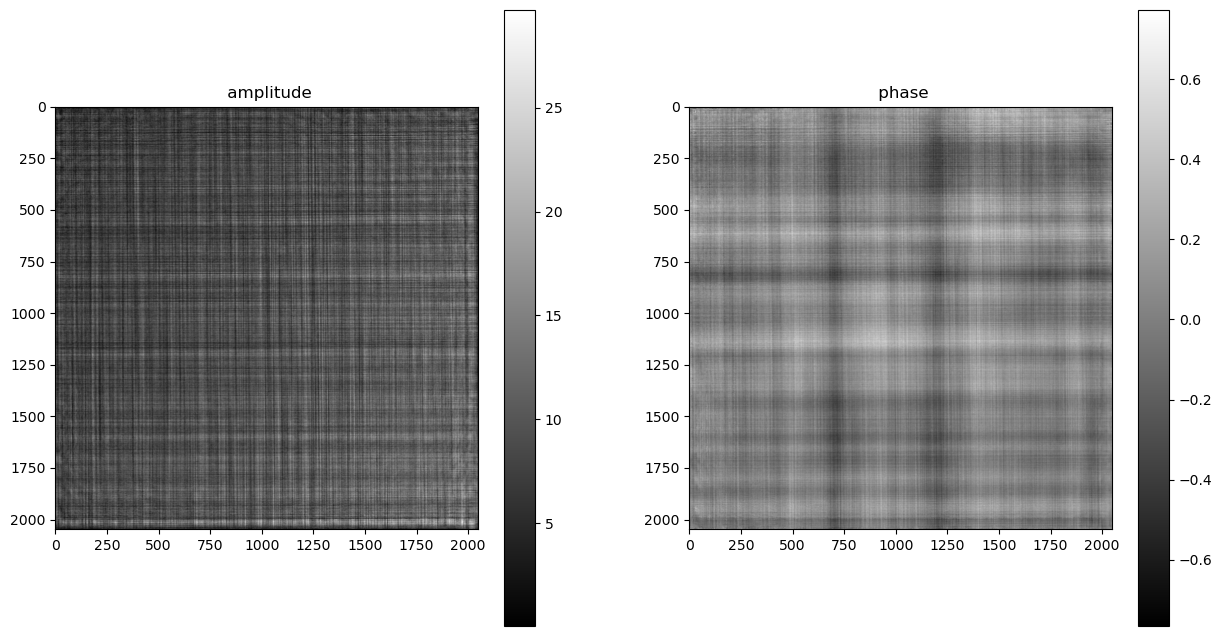

In [2]:
n0 = 2**11
npos = 16
data = np.zeros([npos,1,1,n0,n0],dtype='float32')
for k in range(npos):
    data[k] = dxchange.read_tiff(f'data/modeling/data_codes_{n0}_{k}.tiff')

prb = np.ones([1,n0,n0],dtype='complex64')
prb_abs = dxchange.read_tiff(f'data/modeling/prb_abs{n0}.tiff')
prb_phase = dxchange.read_tiff(f'data/modeling/prb_angle{n0}.tiff')
prb[:] = prb_abs*np.exp(1j*prb_phase)  

psi = np.ones([1,n0,n0],dtype='complex64')
psi_abs = dxchange.read_tiff(f'data/modeling/psiill_abs{n0}.tiff')
psi_phase = dxchange.read_tiff(f'data/modeling/psiill_angle{n0}.tiff')
psi[:] = psi_abs*np.exp(1j*psi_phase)  

fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title(' amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title(' phase')
fig.colorbar(im)


fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title(' amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title(' phase')
fig.colorbar(im)

In [3]:
n = 2**10  # object size in x,y
nz = 2**10  # object size in z    

voxelsize = 10e-9*2048/n # [m] object voxel size 
energy = 33.35  # [keV] x-ray energy    
wavelength = PLANCK_CONSTANT * SPEED_OF_LIGHT / energy # [m]
focusToDetectorDistance = 1.28 # [m]
sx0 = 3.7e-4 # [m] motor offset from the focal spot

z1 = np.tile(np.array([4e-3]),1)-sx0 # positions of the sample (1 position is enough when using several codes)
z2 = focusToDetectorDistance-z1 # propagation distance between the code and detector

magnifications = (z1+z2)/z1 # magnification when propagating from the sample to the code
norm_magnifications = magnifications/magnifications[0] # normalized magnifications
distances = (z1*z2)/(z1+z2) # propagation distances after switching from the point source wave to plane wave,
distances = distances*norm_magnifications**2 # scaled propagation distances due to magnified probes

## Read data

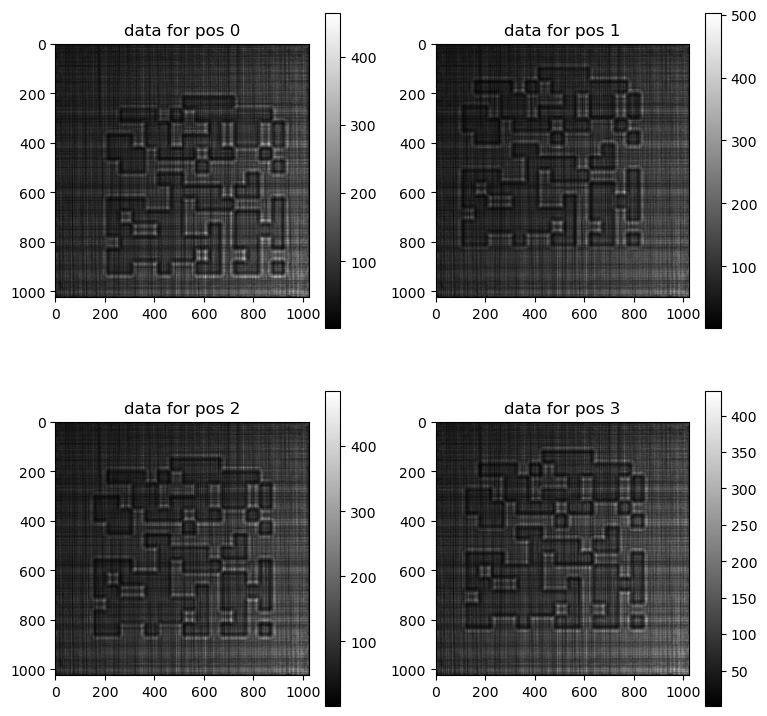

In [4]:
for k in range(int(np.log2(n0//n))):
    data=(data[...,::2,:]+data[...,1::2,:])/2
for k in range(int(np.log2(n0//n))):
    data=(data[...,::2]+data[...,1::2])/2
for k in range(int(np.log2(n0//n))):
    prb=(prb[...,::2,:]+prb[...,1::2,:])/2
for k in range(int(np.log2(n0//n))):
    prb=(prb[...,::2]+prb[...,1::2])/2
for k in range(int(np.log2(n0//n))):
    psi=(psi[...,::2,:]+psi[...,1::2,:])/2
for k in range(int(np.log2(n0//n))):
    psi=(psi[...,::2]+psi[...,1::2])/2
    
fig, axs = plt.subplots(2, 2, figsize=(9, 9))
im=axs[0,0].imshow(data[0,0,0],cmap='gray')
axs[0,0].set_title('data for pos 0')
fig.colorbar(im)
im=axs[0,1].imshow(data[1,0,0],cmap='gray')
axs[0,1].set_title('data for pos 1')
fig.colorbar(im)
im=axs[1,0].imshow(data[-2,0,0],cmap='gray')
axs[1,0].set_title('data for pos 2')
fig.colorbar(im)
im=axs[1,1].imshow(data[-1,0,0],cmap='gray')
axs[1,1].set_title('data for pos 3')
fig.colorbar(im)


## Read the probe

In [5]:
prb = np.ones([1,nz,n],dtype='complex64')
prb_abs = dxchange.read_tiff(f'data/prb_id16a/prb_abs_{n}.tiff')[0]
prb_phase = dxchange.read_tiff(f'data/prb_id16a/prb_phase_{n}.tiff')[0]
prb[:] = prb_abs*np.exp(1j*prb_phase)  

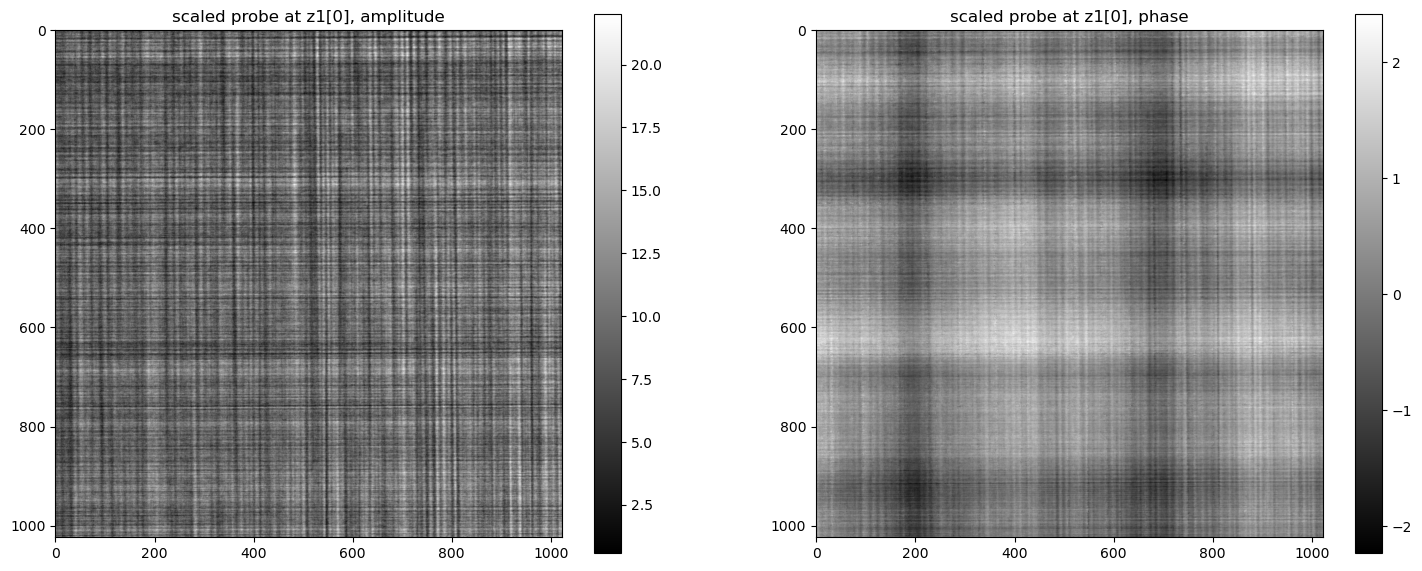

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('scaled probe at z1[0], amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('scaled probe at z1[0], phase')
fig.colorbar(im)

In [7]:
pslv = holotomo.SolverHolo(1, nz, n, 1, voxelsize, energy, distances, norm_magnifications) 

In [8]:
import cupy as cp
def apply_shift(psi, p):
    """Apply shift for all projections."""
    # tmp = cp.zeros([psi.shape[0], 2*nz, 2*n], dtype='complex64')
    # tmp[:, nz//2:3*nz//2, n//2:3*n//2] = psi
    tmp = cp.pad(psi,((0,0),(nz//2,nz//2),(n//2,n//2)),'wrap')
    [x, y] = cp.meshgrid(cp.fft.fftfreq(2*n),
                         cp.fft.fftfreq(2*nz))
    shift = cp.exp(-2*np.pi*1j *
                   (x*p[:, 1, None, None]+y*p[:, 0, None, None]))
    res0 = cp.fft.ifft2(shift*np.fft.fft2(tmp))
    res = res0[:, nz//2:3*nz//2, n//2:3*n//2]
    return res

shifts = cp.array(np.load('shifts.npy')[:npos])

In [9]:
def fwd_nfp(psi,prb):
    psi = cp.tile(psi,[npos,1,1])
    psi = apply_shift(psi,shifts)[:,cp.newaxis].astype('complex64')#.copy()    
    # psi = psi[:,cp.newaxis].astype('complex64')#.copy()    
    fpsi = cp.zeros([npos,1,1,n,n],dtype='complex64')
    for k in range(npos):    
        fpsi[k] = pslv.fwd_holo(psi[k],prb)
    return fpsi

def adj_nfp(fpsi,prb):
    psi = cp.zeros([npos,1,n,n],dtype='complex64')
    for k in range(npos):
        psi[k] = pslv.adj_holo(fpsi[k],prb)
    # print(psi.shape,shifts.shape)
    psi = apply_shift(psi[:,0],-shifts).astype('complex64')#.copy()    
    # psi = psi[:,0].astype('complex64')#.copy()    
    psi = cp.sum(psi,axis=0)[np.newaxis]
    return psi

def adj_nfp_prb(psi,fprb):
    prb = cp.zeros([1,n,n],dtype='complex64')
    psi = cp.tile(psi,[npos,1,1])
    psi = apply_shift(psi,shifts)[:,cp.newaxis].astype('complex64')#.copy()    
    for k in range(npos):
        prb += pslv.adj_holo_prb(fprb[k],psi[k])   
    return prb

In [10]:
import cupy as cp
arr1 = cp.array(data+1j*data).astype('complex64')
prb1 = cp.array(prb)

arr2 = adj_nfp(arr1,prb1)
arr3 = fwd_nfp(arr2,prb1)
print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(arr2*cp.conj(arr2)))

prb2 = adj_nfp_prb(arr2,arr1)
arr3 = fwd_nfp(arr2,prb2)
print(cp.sum(arr1*cp.conj(arr3)))
print(cp.sum(prb2*cp.conj(prb2)))



(347536100000000+0j)
(347536100000000-5144.617j)
(2.0316739e+21-115448720000000j)
(2.0316743e+21-4978516500j)


## Conjugate gradient solver

In [16]:
import cupy as cp
import numpy as np
import holotomo


        
def line_search(minf, gamma, u, fu, d, fd):
    """ Line search for the step sizes gamma"""
    while(minf(u, fu)-minf(u+gamma*d, fu+gamma*fd) < 0 and gamma > 1e-12):
        gamma *= 0.5
    if(gamma <= 1e-12):  # direction not found
        #print('no direction')
        gamma = 0
    return gamma
    
def cg_holo(pslv, data, init, init_prb,  piter, upd_psi=True, upd_prb=False):
    """Conjugate gradients method for holography"""

    # minimization functional
    def minf(psi,fpsi):
        f = cp.linalg.norm(cp.abs(fpsi)-cp.sqrt(data))**2            
        # f = cp.linalg.norm(cp.abs(fpsi)**2-data)**2            
        return f        
    psi = init.copy()
    prb = init_prb.copy()
    
    for i in range(piter):
        if upd_psi:
            fpsi = fwd_nfp(psi,prb)
            grad = adj_nfp(
               fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)), prb)/cp.max(cp.abs(prb))**2
            
            # Dai-Yuan direction
            if i == 0:
                d = -grad
            else:
                d = -grad+cp.linalg.norm(grad)**2 / \
                    ((cp.sum(cp.conj(d)*(grad-grad0))))*d
            grad0 = grad
            # line search
            fd = fwd_nfp(d, prb)
            gammapsi = line_search(minf, 1, psi, fpsi, d, fd)
            psi = psi + gammapsi*d
    
            err=minf(psi,fpsi)
            print(f'{i}) {gammapsi=}, {err=:1.2e}')    
        
        if upd_prb:
            fpsi = fwd_nfp(psi,prb)
            gradprb = adj_nfp_prb(psi,
               fpsi-cp.sqrt(data)*cp.exp(1j*cp.angle(fpsi)))/cp.max(cp.abs(psi))**2/npos/npos
            
            # Dai-Yuan direction
            if i == 0:
                dprb = -gradprb
            else:
                dprb = -gradprb+cp.linalg.norm(gradprb)**2 / \
                    ((cp.sum(cp.conj(dprb)*(gradprb-gradprb0))))*dprb
            gradprb0 = gradprb
            # line search
            fdprb = fwd_nfp(dprb, prb)
            gammaprb = line_search(minf, 1, psi, fpsi, dprb, fdprb)
            prb = prb + gammaprb*dprb
                



        
            err=minf(psi,fpsi)
            print(f'{i}) {gammaprb=}, {err=:1.2e}')    
        
            
    
    return psi,prb

def cg_holo_batch(pslv, data, init, prb_init, piter,upd_psi=True,upd_prb=False):
    """Batch of CG solvers"""
    
    res = np.zeros([pslv.ntheta, pslv.nz, pslv.n], dtype='complex64')
    prb_init_gpu = cp.array(prb_init)                
    for ids in holotomo.utils.chunk(range(pslv.ntheta), pslv.ptheta):
        # copy data part to gpu
        data_gpu = cp.array(data[:,ids])
        init_gpu = cp.array(init[ids])
        
        # Radon transform
        res_gpu,res_prb_gpu = cg_holo(pslv, data_gpu, init_gpu,prb_init_gpu, piter,upd_psi, upd_prb)
        # copy result to cpu
        res[ids] = res_gpu.get()
        res_prb = res_prb_gpu.get()
    return res,res_prb


piter = 32 # number of CG iters

rec = np.ones([1,nz,n],dtype='complex64')#*np.exp(-0.7j)  # initial guess
rec_prb = prb.copy()#np.ones([1,nz,n],dtype='complex64')#*np.exp(-0.7j)  # initial guess
# rec_prb = np.exp(1j*np.angle(prb)/4)
rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 32, True,False)
# rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 32, False,True)
# rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb, 32, True,True)
# rec,rec_prb = cg_holo_batch(pslv, data, rec, rec_prb,  piter, True)



0) gammapsi=0.5, err=1.45e+08
1) gammapsi=1, err=1.28e+08
2) gammapsi=1, err=1.25e+08
3) gammapsi=1, err=1.19e+08
4) gammapsi=1, err=1.17e+08
5) gammapsi=1, err=1.14e+08
6) gammapsi=0.5, err=1.13e+08
7) gammapsi=1, err=1.09e+08
8) gammapsi=1, err=1.09e+08
9) gammapsi=0.5, err=1.08e+08
10) gammapsi=1, err=1.06e+08
11) gammapsi=0.5, err=1.05e+08
12) gammapsi=1, err=1.04e+08
13) gammapsi=1, err=1.04e+08
14) gammapsi=0.5, err=1.03e+08
15) gammapsi=1, err=1.03e+08
16) gammapsi=0.5, err=1.03e+08
17) gammapsi=1, err=1.02e+08
18) gammapsi=1, err=1.02e+08
19) gammapsi=0.5, err=1.02e+08
20) gammapsi=0.5, err=1.01e+08
21) gammapsi=1, err=1.01e+08
22) gammapsi=0.5, err=1.01e+08
23) gammapsi=1, err=1.01e+08
24) gammapsi=0.5, err=1.01e+08
25) gammapsi=1, err=1.00e+08
26) gammapsi=0.5, err=1.00e+08
27) gammapsi=1, err=1.00e+08
28) gammapsi=0.5, err=1.00e+08
29) gammapsi=1, err=9.99e+07
30) gammapsi=0.5, err=9.99e+07
31) gammapsi=1, err=9.97e+07


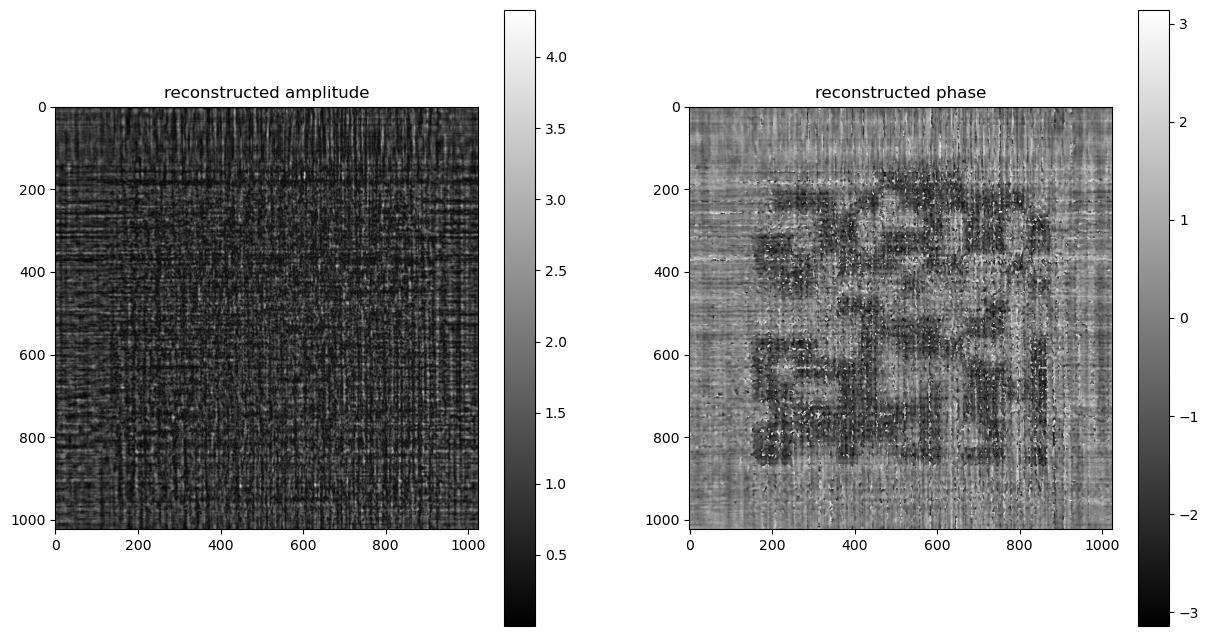

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(rec[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(rec[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

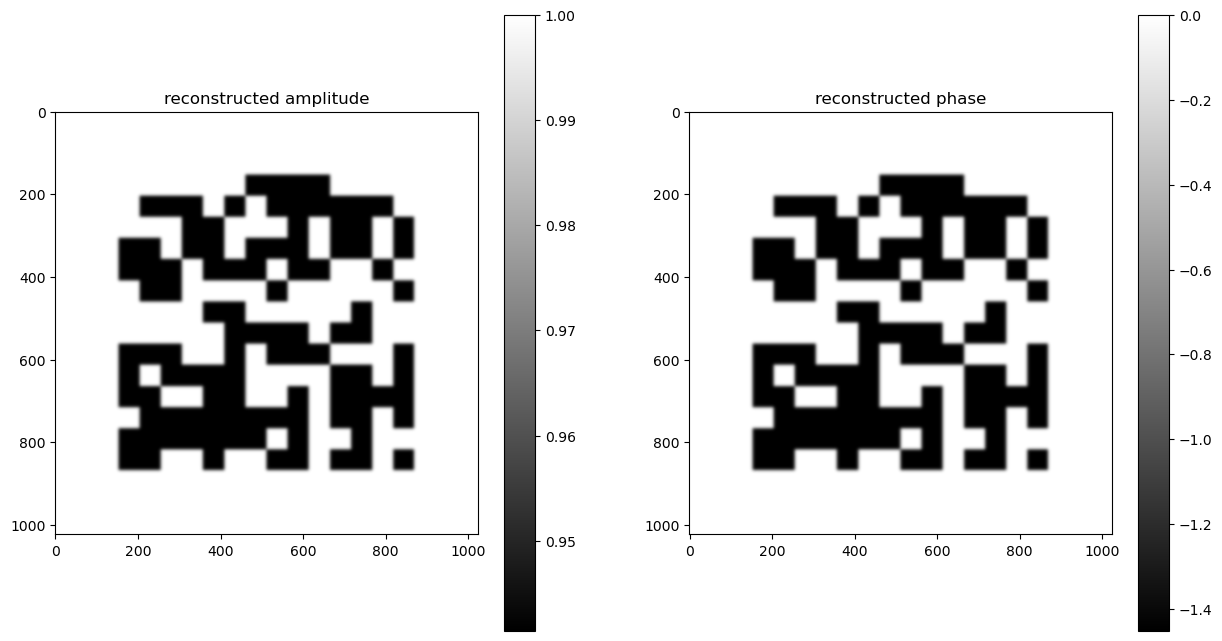

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(psi[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(psi[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

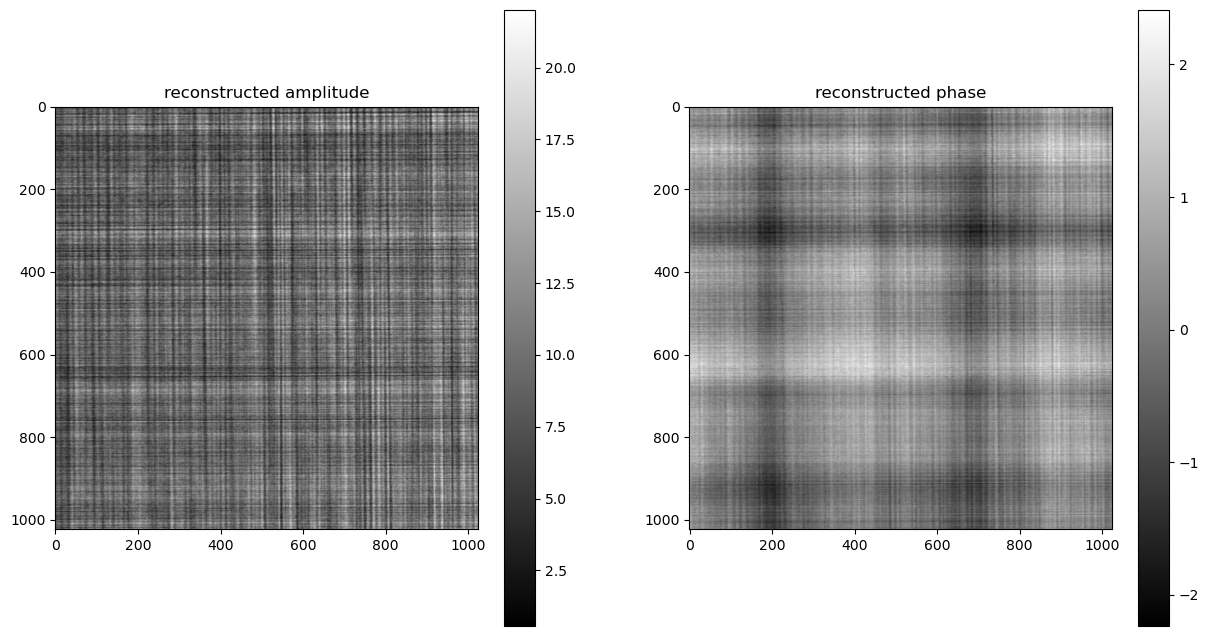

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8))
im=axs[0].imshow(np.abs(prb[0]),cmap='gray')
axs[0].set_title('reconstructed amplitude')
fig.colorbar(im)
im=axs[1].imshow(np.angle(prb[0]),cmap='gray')
axs[1].set_title('reconstructed phase')
fig.colorbar(im)

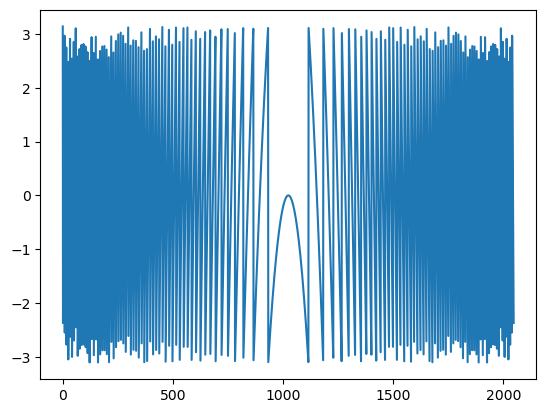

In [30]:
n = 1024
distance = 0.005
wavelength = 4e-11
fx = np.fft.fftshift(np.fft.fftfreq(2*n,d=voxelsize))
[fx,fy] = np.meshgrid(fx,fx)            
fP = np.exp(-1j*np.pi*wavelength*distance*(fx**2+fy**2))

# plt.imshow(np.angle(fP))
# plt.colorbar()
plt.plot(np.angle(fP[n]))